In [3]:
import pandas as pd  
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, GridSearchCV
import altair as alt
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from pyarrow import feather

import os.path
from os import path
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [4]:
assert path.exists("../data/train.feather") == True, "Input file does not exist"

In [5]:
# load in feather datasets 
# training dataset
avocado = pd.read_feather("../data/train.feather")
avocado.head()
# test dataset
# avocado_test = pd.read_feather("test.feather")
# avocado_test.head()

,ix,date,average_price,total_volume,PLU_4046,PLU_4225,PLU_4770,total_bags,small_bags,large_bags,xlarge_bags,type,year,region,month,year_month,lat,lon,season
0,0.0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015.0,Albany,Dec,2015-12,42.65258,-73.756233,Winter
1,1.0,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015.0,Albany,Dec,2015-12,42.65258,-73.756233,Winter
2,2.0,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015.0,Albany,Dec,2015-12,42.65258,-73.756233,Winter
3,3.0,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015.0,Albany,Dec,2015-12,42.65258,-73.756233,Winter
4,4.0,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015.0,Albany,Nov,2015-11,42.65258,-73.756233,Fall


In [3]:
# Which features do we want to keep?
avocado.columns
# want season, lat, lon, and type as our features

Index(['X1', 'date', 'average_price', 'total_volume', 'PLU_4046', 'PLU_4225',
       'PLU_4770', 'total_bags', 'small_bags', 'large_bags', 'xlarge_bags',
       'type', 'year', 'region', 'month', 'year_month', 'lat', 'lon',
       'season'],
      dtype='object')

In [6]:
# Split the data into target and features
avocado_x = avocado[['lat', 'lon', 'type', 'season']]
avocado_y = avocado['average_price']

# avocado_test_x = avocado_test[['region', 'type', 'month']]
# avocado_test_y = avocado['AveragePrice']

# Scale the numerical features (don't need for rfr, but can't hurt)
numeric_features = ['lat', 'lon']

# need to convert categorical to numerical using one-hot-encoding
categorical_features = ['type', 'season']

preprocessor = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), numeric_features),
    ('ohe', OneHotEncoder(), categorical_features)
])

# applying one hot encoding to the training features
avocado_x = pd.DataFrame(preprocessor.fit_transform(avocado_x),
                         index=avocado_x.index,
                         columns = (numeric_features +
                                   list(preprocessor.named_transformers_['ohe']
                                       .get_feature_names(categorical_features))))

# apply the same transformation to the test features (but don't fit!)

# avocado_test_x = pd.DataFrame(preprocessor.transform(avocado_test_x),
#                              index=avocado_test_x.index,
#                              columns=avocado_x.columns)

In [7]:
assert len(avocado_x.columns) == 8

In [8]:
# fit rfr model
rfr = RandomForestRegressor(random_state=123)
rfr.fit(avocado_x, avocado_y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)

In [9]:
fold_accuracies = cross_val_score(estimator=rfr, X=avocado_x, y=avocado_y, cv=5)
print(fold_accuracies)
print(np.mean(fold_accuracies))
print(np.std(fold_accuracies))
# the standard deviation is much greater than the mean accuracy, 
# this is probably not a good model...

[-0.71236607  0.17668574  0.52865414 -0.05899086  0.1797582 ]
0.022748230814118343
0.41264124553151404


In [10]:
# find optimal hyperparameters

rfr_parameters = {'max_depth': range(1, 20),
                  'n_estimators': range(1, 100)}

random_rfr = RandomizedSearchCV(rfr, rfr_parameters, n_iter=10,
             cv=5)

random_rfr.fit(avocado_x, avocado_y).best_params_

{'n_estimators': 46, 'max_depth': 10}

In [11]:
fold_accuracies = cross_val_score(estimator=random_rfr, X=avocado_x, y=avocado_y, cv=5)
cv_scores = pd.DataFrame({'Fold': [1, 2, 3, 4, 5],
                  'Negative_Mean_Squared_Error': fold_accuracies})
#for i in range(5):
#    cv_scores_dict('Fold')[i] = 

#print(fold_accuracies)
#print(np.mean(fold_accuracies))
#print(np.std(fold_accuracies))
# The standard error is much more reasonable here

In [12]:
cv_scores

,Fold,Negative_Mean_Squared_Error
0,1,-0.638558
1,2,0.191136
2,3,0.544018
3,4,0.012068
4,5,0.168815


In [13]:
assert cv_scores['Negative_Mean_Squared_Error'].all() != 0

In [15]:
np.mean(cv_scores['Negative_Mean_Squared_Error'])

0.055495622391303276

In [40]:
feature_list = list(avocado_x.columns)
nice_feature_list = ['Latitude', 'Longitude',
                     'Conventional Type', 'Organic Type',
                     'Fall Season', 'Spring Season',
                     'Summer Season', 'Winter Season']

In [41]:
feature_df = pd.DataFrame({"feature_names": nice_feature_list,
             "importance": random_rfr.best_estimator_.feature_importances_})

In [42]:
feature_df.sort_values(["importance"], ascending=False, inplace=True)

In [43]:
feature_df.reset_index(drop=True, inplace=True)

In [44]:
feature_df

,feature_names,importance
0,Organic Type,0.343258
1,Conventional Type,0.221314
2,Longitude,0.216016
3,Latitude,0.127150
4,Fall Season,0.047994
5,Summer Season,0.026078
6,Winter Season,0.012480
7,Spring Season,0.005709


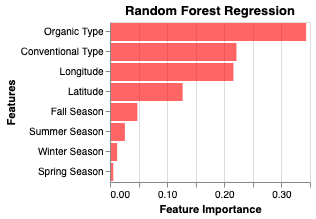

In [53]:
rfr_plot = alt.Chart(feature_df).mark_bar(color="red", opacity=0.6).encode(
    y= alt.Y("feature_names:N",
             sort=alt.SortField(field='importance:Q'),
             title="Features"),
    x = alt.X("importance:Q", title="Feature Importance")
).properties(title="Random Forest Regression",
             width=200)

rfr_plot

In [22]:
rfr.score(avocado_x, avocado_y)

0.6681831284194752

In [23]:
lr = Lasso()

param_grid = {"alpha": [i for i in range(0, 1000, 1)]}

lr_rs = RandomizedSearchCV(lr, param_grid, cv=5).fit(avocado_x, avocado_y)

lr_rs.best_params_

lr2 = Lasso(alpha=335)

lr2.fit(avocado_x, avocado_y)

#lr.fit(avocado_x, avocado_y)

Lasso(alpha=335, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [24]:
fold_accuracies_lr = cross_val_score(estimator=lr2, X=avocado_x, y=avocado_y, cv=5)
cv_scores_dict_lr = {'Fold': [1, 2, 3, 4, 5],
                  'Negative_Mean_Squared_Error': fold_accuracies_lr}
pd.DataFrame(cv_scores_dict_lr)

,Fold,Negative_Mean_Squared_Error
0,1,-3.982792
1,2,-0.830008
2,3,-0.023900
3,4,-0.480140
4,5,-0.776321


In [25]:
np.mean(cv_scores_dict_lr['Negative_Mean_Squared_Error'])

-1.218632137672872

In [26]:
lr2.score(avocado_x, avocado_y)

0.0

In [27]:
list(zip(feature_list, lr2.coef_))

[('lat', 0.0),
 ('lon', 0.0),
 ('type_conventional', -0.0),
 ('type_organic', 0.0),
 ('season_Fall', 0.0),
 ('season_Spring', -0.0),
 ('season_Summer', 0.0),
 ('season_Winter', -0.0)]

Now try L2 regularization

In [28]:

r = Ridge()

param_grid = {"alpha": [i for i in range(0, 1000, 1)]}

r_rs = RandomizedSearchCV(r, param_grid, cv=5, random_state=123).fit(avocado_x, avocado_y)

r_rs.best_params_['alpha']

r2 = Ridge(alpha=r_rs.best_params_['alpha'])

r2.fit(avocado_x, avocado_y)

Ridge(alpha=17, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [29]:
fold_accuracies_r = cross_val_score(estimator=r2, X=avocado_x, y=avocado_y, cv=5)
cv_scores_dict_r = {'Fold': [1, 2, 3, 4, 5],
                  'Negative_Mean_Squared_Error': fold_accuracies_r}
pd.DataFrame(cv_scores_dict_r)

,Fold,Negative_Mean_Squared_Error
0,1,-0.458910
1,2,0.220691
2,3,0.416648
3,4,-0.050961
4,5,0.004860


In [30]:
np.mean(cv_scores_dict_r['Negative_Mean_Squared_Error'])

0.0264655266731992

In [31]:
list(zip(feature_list, r2.coef_))

[('lat', 0.040904885778869325),
 ('lon', 0.0369545115458163),
 ('type_conventional', -0.24978385350368837),
 ('type_organic', 0.2497838535037117),
 ('season_Fall', 0.12179872661856912),
 ('season_Spring', -0.06179872109565188),
 ('season_Summer', 0.0503069190869013),
 ('season_Winter', -0.11030692460978973)]

In [47]:
lr_feature_df = pd.DataFrame({"feature_names": nice_feature_list,
         "weights": r2.coef_})
lr_feature_df = lr_feature_df.sort_values(["weights"], ascending=False)
lr_feature_df

,feature_names,weights
3,Organic Type,0.249784
4,Fall Season,0.121799
6,Summer Season,0.050307
0,Latitude,0.040905
1,Longitude,0.036955
5,Spring Season,-0.061799
7,Winter Season,-0.110307
2,Conventional Type,-0.249784


In [51]:
lr_plot = alt.Chart(lr_feature_df).mark_bar(color="blue", opacity=0.6).encode(
    y = alt.Y("feature_names:N",
              sort=alt.SortField(field="abs(weights):Q"),
              title="Features"),
    x = alt.X("weights:Q", title="Coefficient Weights")
).properties(title="Linear Regression",
       width=200)

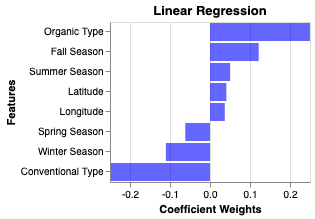

In [52]:
lr_plot

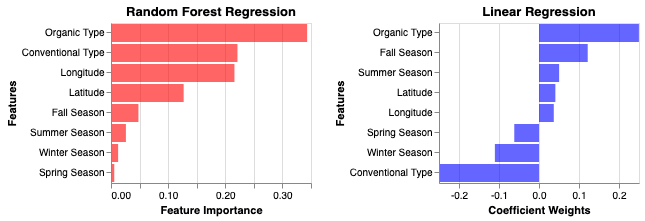

In [54]:
rfr_plot | lr_plot